In [23]:
import pandas as pd
import numpy as np

In [125]:
df = pd.read_csv("../sp500_ohlcv_2005_2025_2.csv")

In [126]:

# Suppose df a les colonnes : Date, Ticker, Open, High, Low, Close, Volume
df = df.sort_values(["Ticker", "Date"])

# --- 1) Log-return
df["log_return"] = np.log(df["Close"]) - np.log(df["Close"].shift(1))

# --- 2) Target direction (r_{t+1} > 0)
df["target"] = (df.groupby("Ticker")["log_return"].shift(-1) > 0).astype(int)

# --- 3) Features momentum
df["mom_5"]  = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(5) - 1)
df["mom_21"] = df.groupby("Ticker")["Close"].transform(lambda x: x / x.shift(21) - 1)

# --- 4) Features volatilité
df["vol_5"]  = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(5).std())
df["vol_21"] = df.groupby("Ticker")["log_return"].transform(lambda x: x.rolling(21).std())

# --- 5) High–Low range
df["range"] = (df["High"] - df["Low"]) / df["Open"]

# --- 6) Volume z-score
df["volume_z"] = df.groupby("Ticker")["Volume"].transform(
    lambda x: (x - x.mean()) / x.std()
)

df['Return'] = df.groupby('Ticker')['Close'].pct_change(fill_method=None)

# --- 7) Clean
df = df.dropna()


In [127]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()  # lève une erreur si 4xx/5xx

tables = pd.read_html(resp.text, header=0)
sp500 = tables[0]

sp500 = sp500.rename(columns={"Symbol": "Ticker", "GICS Sector": "Sector"})
sp500['Ticker'] = sp500['Ticker'].str.replace('.', '-', regex=False)

df = df.sort_values(by=['Ticker', 'Date'])

df = df.merge(
    sp500[['Ticker', 'Sector']], 
    on='Ticker', 
    how='left'
)

df.tail()

/tmp/ipykernel_45849/543082282.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=0)


,Date,Ticker,Open,High,Low,Close,Volume,log_return,target,mom_5,mom_21,vol_5,vol_21,range,volume_z,Return,Sector
2278836,2024-12-24,ZTS,161.553123,162.875546,160.605722,162.540009,1023600.0,0.002553,1,-0.035658,-0.069281,0.013838,0.011887,0.014050,-0.714869,0.002557,Health Care
2278837,2024-12-26,ZTS,161.572877,163.615722,160.882060,163.349274,2167200.0,0.004967,0,-0.008921,-0.073807,0.011590,0.011660,0.016919,-0.256480,0.004979,Health Care
2278838,2024-12-27,ZTS,162.786715,164.345996,161.375477,162.441315,1800100.0,-0.005574,0,0.006605,-0.063176,0.005697,0.011267,0.018248,-0.403625,-0.005558,Health Care
2278839,2024-12-30,ZTS,161.740613,161.898519,159.332611,160.112259,1531400.0,-0.014442,1,-0.015773,-0.082041,0.007613,0.011328,0.015864,-0.511328,-0.014338,Health Care
2278840,2024-12-31,ZTS,160.763608,161.602466,159.747117,160.793213,1327400.0,0.004244,0,-0.008218,-0.070300,0.008295,0.011421,0.011541,-0.593097,0.004253,Health Care


la variable Sector est catégorielle par conséquent on va l'encoder par par la volatilité moyenne du secteur. Ce choix est motivé par la raison suivante. On veut faire comprendre au modèle que certains secteurs sont très volatils et très dépendants de chocs extérieur ainsi pour ces secteurs la, l'évolution futur de l'action est moins évidente.

In [140]:
# 1) Calcul de volatilité moyenne par secteur
sector_vol_mean = df.groupby("Sector")["vol_21"].mean()

# 2) Encodage de Sector par cette moyenne
df["Sector_encoded"] = df["Sector"].map(sector_vol_mean)


In [212]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report



def regression(df, features):

    # --- 8) Train/val/test split
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()   # copy important

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)


    # --- Autres métriques globales
    print("Accuracy :", accuracy_score(y_test, y_pred))

    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return  model, sector_f1


In [213]:
regression(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])


Accuracy : 0.5177679134039983


(LogisticRegression(max_iter=1000),
 Sector
 Financials                0.524993
 Utilities                 0.521979
 Industrials               0.521291
 Real Estate               0.520815
 Energy                    0.518289
 Information Technology    0.516843
 Consumer Staples          0.516335
 Consumer Discretionary    0.515701
 Health Care               0.511678
 Communication Services    0.509799
 Materials                 0.506109
 dtype: float64)

De premier abord, la regression parait ne pas être suffisante pour prédire le signe du rendement

In [210]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

def training(df, features):

    # --- 8) Train/val/test split
    train = df[df["Date"] < "2018-01-01"]
    val   = df[(df["Date"] >= "2018-01-01") & (df["Date"] < "2021-01-01")]
    test  = df[df["Date"] >= "2021-01-01"].copy()   # copy important

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)


    # --- Autres métriques globales
    print("Accuracy :", accuracy_score(y_test, y_pred))
    # print("F1        :", f1_score(y_test, y_pred))
    # print("AUC       :", roc_auc_score(y_test, y_pred_proba))
    # print()
    # print(confusion_matrix(y_test, y_pred))
    # print()
    # print(classification_report(y_test, y_pred))

     # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    return  sector_f1


In [211]:
training(df, ["Close", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])

Accuracy : 0.5128854497365115


Sector
Financials                0.518164
Utilities                 0.517800
Real Estate               0.516996
Information Technology    0.515275
Materials                 0.515144
Industrials               0.512890
Energy                    0.512804
Consumer Staples          0.511715
Communication Services    0.507419
Health Care               0.506284
Consumer Discretionary    0.506053
dtype: float64

Accuracy : 0.5140293068226058
F1        : 0.6218637768964117
AUC       : 0.5068100670787674

[[ 57021 183764]
 [ 58402 199127]]

              precision    recall  f1-score   support

           0       0.49      0.24      0.32    240785
           1       0.52      0.77      0.62    257529

    accuracy                           0.51    498314
   macro avg       0.51      0.51      0.47    498314
weighted avg       0.51      0.51      0.48    498314



/tmp/ipykernel_45849/2066407559.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


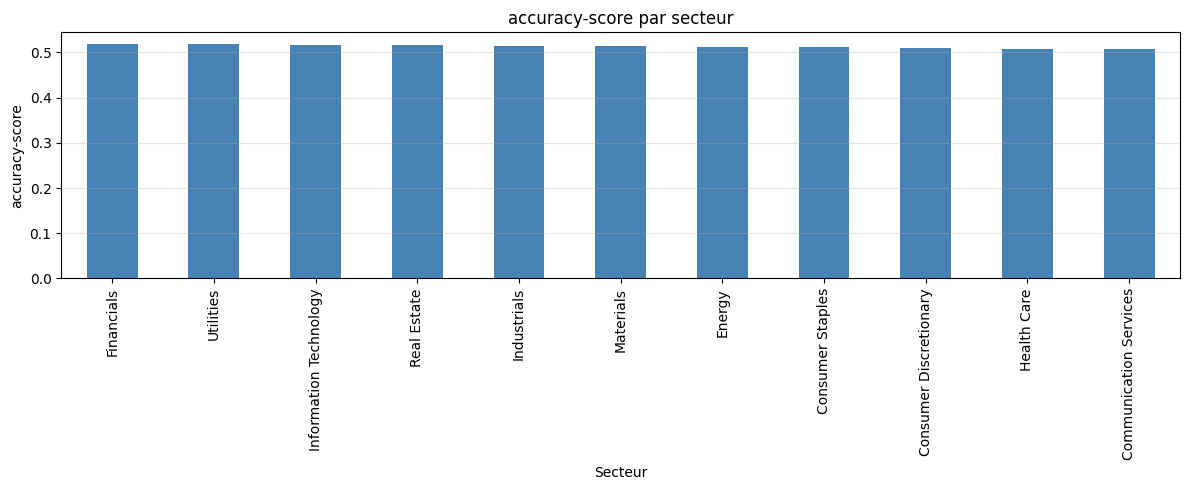

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=None, num_parallel_tree=None, ...),
 Sector
 Financials                0.518523
 Utilities                 0.517638
 Information Technology    0.517502
 Real Estate               0.516803
 Industrials               0.514599
 Materials                 0.514428
 Energy 

In [118]:
training(df, ["mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])

Accuracy : 0.515229353379596
F1        : 0.6262813471743065
AUC       : 0.5081305382876811

[[ 54335 186450]
 [ 55118 202411]]

              precision    recall  f1-score   support

           0       0.50      0.23      0.31    240785
           1       0.52      0.79      0.63    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.47    498314
weighted avg       0.51      0.52      0.47    498314



/tmp/ipykernel_45849/2066407559.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


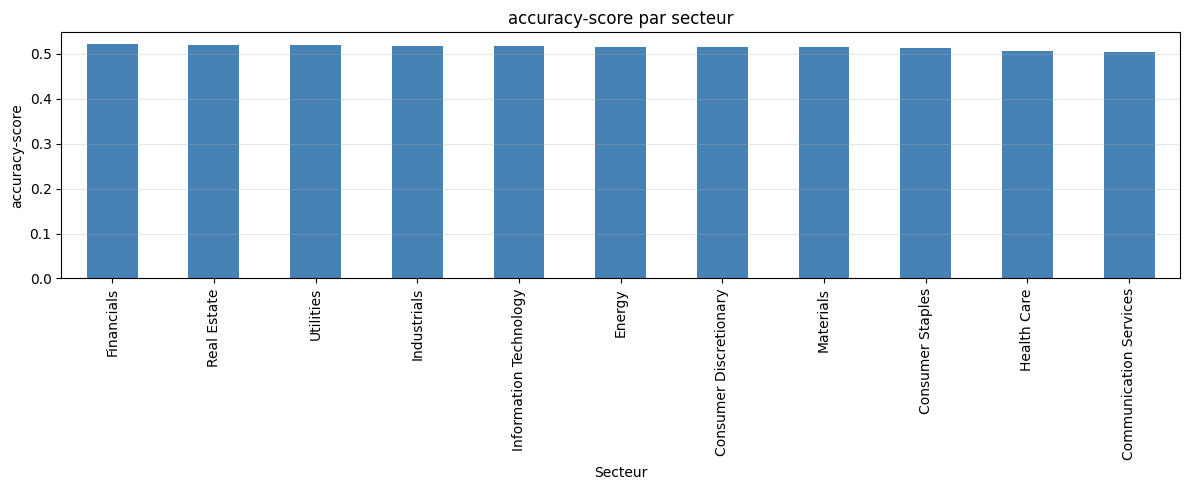

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=None, num_parallel_tree=None, ...),
 Sector
 Financials                0.521412
 Real Estate               0.519275
 Utilities                 0.518707
 Industrials               0.516551
 Information Technology    0.516432
 Energy                    0.515660
 Consume

In [119]:
training(df, ["mom_5", "vol_5", "vol_21", "range", "volume_z"])


In [143]:
training(df, ["mom_5", "vol_5", "range", "volume_z"])

Accuracy : 0.5158634916939921
F1        : 0.6269202814505529
AUC       : 0.5084078955526526

[[ 54363 186422]
 [ 54830 202699]]

              precision    recall  f1-score   support

           0       0.50      0.23      0.31    240785
           1       0.52      0.79      0.63    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.47    498314
weighted avg       0.51      0.52      0.47    498314



/tmp/ipykernel_45849/1332441287.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


Sector
Financials                0.521732
Utilities                 0.521104
Real Estate               0.518729
Industrials               0.518517
Materials                 0.517851
Information Technology    0.517502
Energy                    0.515796
Consumer Discretionary    0.512613
Consumer Staples          0.512262
Health Care               0.507862
Communication Services    0.503093
dtype: float64

In [139]:
training(df, ["mom_5", "vol_5", "range", "volume_z", "Return"])


Accuracy : 0.512750996359725
F1        : 0.6101222447560645
AUC       : 0.5071669703843685

[[ 65529 175256]
 [ 67547 189982]]

              precision    recall  f1-score   support

           0       0.49      0.27      0.35    240785
           1       0.52      0.74      0.61    257529

    accuracy                           0.51    498314
   macro avg       0.51      0.50      0.48    498314
weighted avg       0.51      0.51      0.48    498314



/tmp/ipykernel_45849/1332441287.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


Sector
Materials                 0.518090
Financials                0.516460
Real Estate               0.516290
Utilities                 0.515306
Energy                    0.514572
Industrials               0.514380
Information Technology    0.511583
Consumer Staples          0.510895
Consumer Discretionary    0.509099
Communication Services    0.508285
Health Care               0.507014
dtype: float64

In [141]:
training(df, ["mom_5", "vol_5", "range", "volume_z", "Sector_encoded"])

Accuracy : 0.5153658135232002
F1        : 0.6216891929996052
AUC       : 0.5087838770598949

[[ 58382 182403]
 [ 59097 198432]]

              precision    recall  f1-score   support

           0       0.50      0.24      0.33    240785
           1       0.52      0.77      0.62    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.47    498314
weighted avg       0.51      0.52      0.48    498314



/tmp/ipykernel_45849/1332441287.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


Sector
Energy                    0.521325
Utilities                 0.520327
Real Estate               0.519178
Materials                 0.519085
Information Technology    0.518953
Industrials               0.518285
Financials                0.515781
Consumer Staples          0.513383
Consumer Discretionary    0.510013
Health Care               0.507302
Communication Services    0.507203
dtype: float64

Accuracy : 0.5152072789446012
F1        : 0.6318857893429596
AUC       : 0.5079054399643965

[[ 49394 191391]
 [ 50188 207341]]

              precision    recall  f1-score   support

           0       0.50      0.21      0.29    240785
           1       0.52      0.81      0.63    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.46    498314
weighted avg       0.51      0.52      0.47    498314



/tmp/ipykernel_45849/2066407559.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


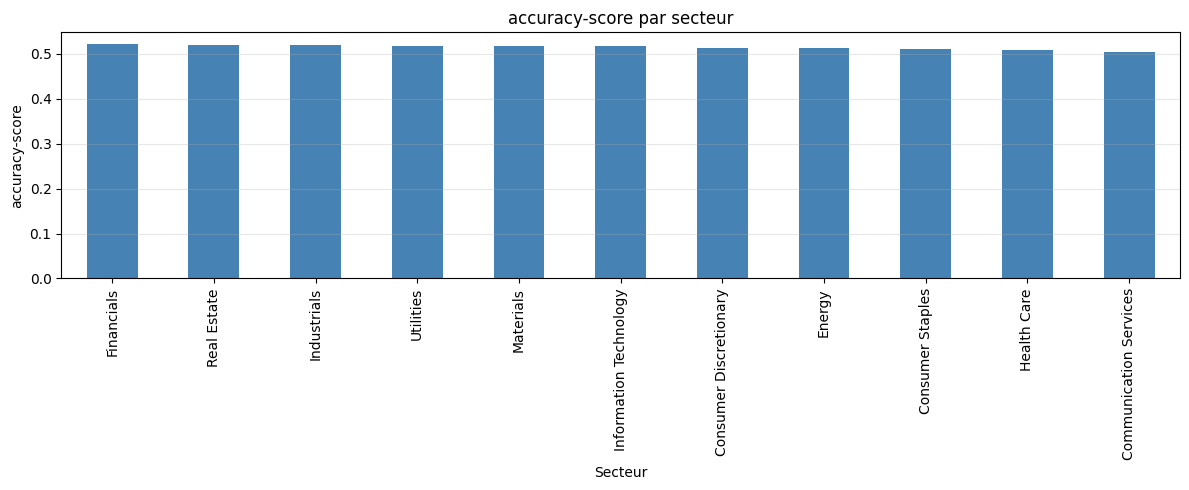

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=None, num_parallel_tree=None, ...),
 Sector
 Financials                0.521306
 Real Estate               0.518633
 Industrials               0.518452
 Utilities                 0.516925
 Materials                 0.516697
 Information Technology    0.516579
 Consume

In [121]:
training(df, ["mom_5", "vol_5", "volume_z"])

Accuracy : 0.5122653587898394
F1        : 0.6076939094053708
AUC       : 0.5074295699895622

[[ 67027 173758]
 [ 69287 188242]]

              precision    recall  f1-score   support

           0       0.49      0.28      0.36    240785
           1       0.52      0.73      0.61    257529

    accuracy                           0.51    498314
   macro avg       0.51      0.50      0.48    498314
weighted avg       0.51      0.51      0.49    498314



/tmp/ipykernel_45849/2066407559.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


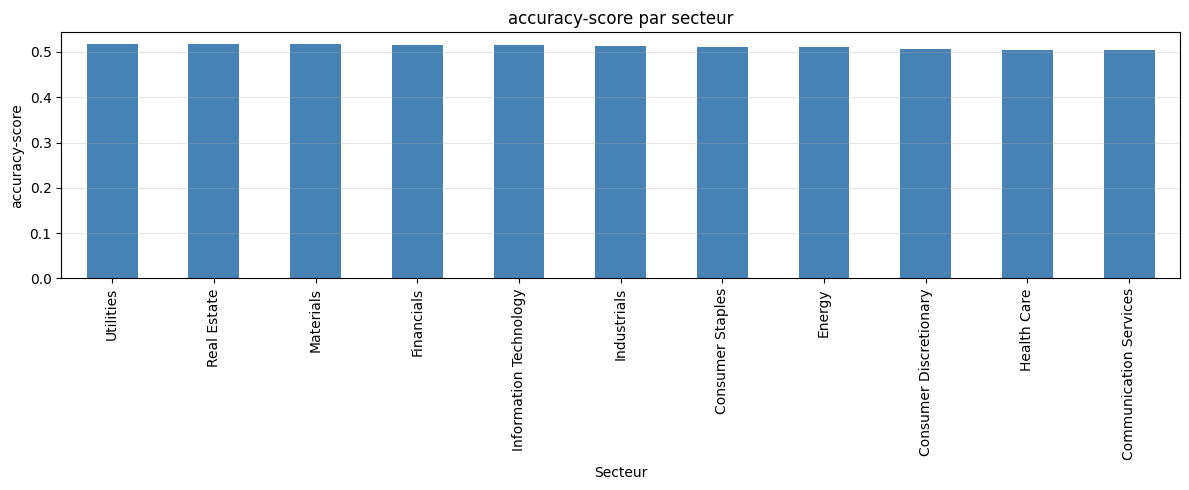

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=None, num_parallel_tree=None, ...),
 Sector
 Utilities                 0.517508
 Real Estate               0.517381
 Materials                 0.516577
 Financials                0.516287
 Information Technology    0.514762
 Industrials               0.512890
 Consume

In [122]:
training(df, ["Open", "Close", "High", "Low", "Volume", "mom_5", "mom_21", "vol_5", "vol_21", "range", "volume_z"])

Accuracy : 0.5141416857643976
F1        : 0.6295293181539968
AUC       : 0.5070334552745811

[[ 50499 190286]
 [ 51824 205705]]

              precision    recall  f1-score   support

           0       0.49      0.21      0.29    240785
           1       0.52      0.80      0.63    257529

    accuracy                           0.51    498314
   macro avg       0.51      0.50      0.46    498314
weighted avg       0.51      0.51      0.47    498314



/tmp/ipykernel_45849/2066407559.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


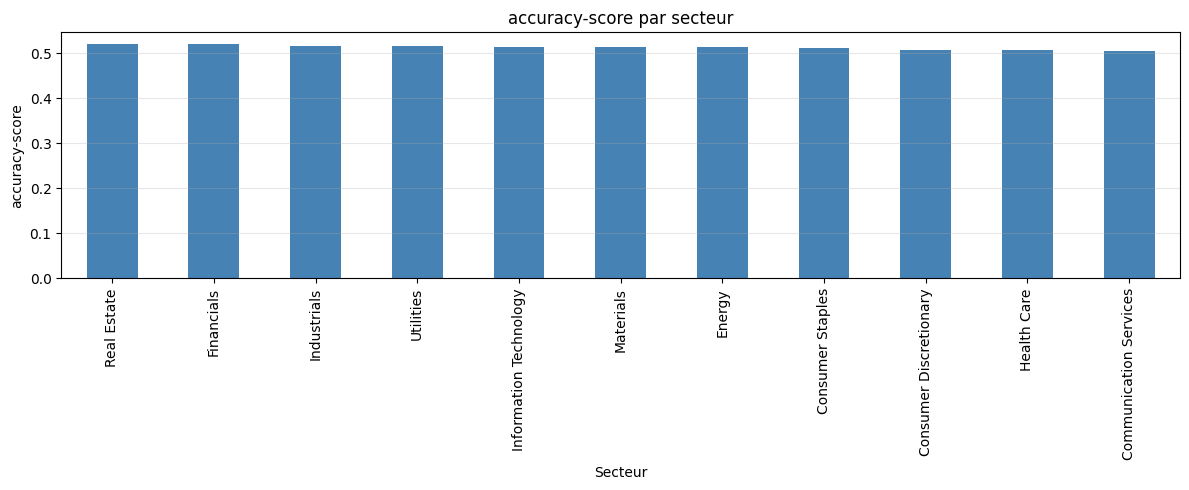

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.7, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.03, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=800,
               n_jobs=None, num_parallel_tree=None, ...),
 Sector
 Real Estate               0.520879
 Financials                0.520840
 Industrials               0.516782
 Utilities                 0.516051
 Information Technology    0.514484
 Materials                 0.513950
 Energy 

In [124]:
training(df, ["mom_5", "vol_5", "range", "volume_z"])

In [144]:
training(df, ["mom_5", "vol_5", "range"])

Accuracy : 0.5166922863897061
F1        : 0.6347653732357308
AUC       : 0.5078330323978835

[[ 48190 192595]
 [ 48244 209285]]

              precision    recall  f1-score   support

           0       0.50      0.20      0.29    240785
           1       0.52      0.81      0.63    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.46    498314
weighted avg       0.51      0.52      0.47    498314



/tmp/ipykernel_45849/1332441287.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


Sector
Financials                0.521199
Industrials               0.521163
Utilities                 0.520618
Real Estate               0.517926
Energy                    0.517699
Materials                 0.517134
Information Technology    0.516887
Consumer Staples          0.513875
Consumer Discretionary    0.513690
Health Care               0.509507
Communication Services    0.507246
dtype: float64

In [148]:
training(df, ["mom_5", "vol_5", "range"])

Accuracy : 0.5166922863897061
F1        : 0.6347653732357308
AUC       : 0.5078330323978835

[[ 48190 192595]
 [ 48244 209285]]

              precision    recall  f1-score   support

           0       0.50      0.20      0.29    240785
           1       0.52      0.81      0.63    257529

    accuracy                           0.52    498314
   macro avg       0.51      0.51      0.46    498314
weighted avg       0.51      0.52      0.47    498314



/tmp/ipykernel_45849/1332441287.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g["target"], g["pred"]))


Sector
Financials                0.521199
Industrials               0.521163
Utilities                 0.520618
Real Estate               0.517926
Energy                    0.517699
Materials                 0.517134
Information Technology    0.516887
Consumer Staples          0.513875
Consumer Discretionary    0.513690
Health Care               0.509507
Communication Services    0.507246
dtype: float64

meme en ajoutant des variable pertinentes, l'accuracy reste sensiblement la meme peu importe le secteur. L'accuracy max réalisé est 0.5167. Peut etre qu'étant donné le fait que les années d'entrainement sont très anciennes par rapport aux années de test le modèle est mal adapté aux nouvelles années

Changeons de méthode d'entrainement : éparpillons des années de test et de validation dans tous le dataset

# Ajout de la variable secteur

In [161]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

def training2(df, features):

    # --- 8) Train/val/test split
    mask_train = (
        df["Date"].between("2004-01-01", "2008-01-01") |
        df["Date"].between("2010-01-01", "2013-01-01") |
        df["Date"].between("2015-01-01", "2018-01-01") |
        df["Date"].between("2020-01-01", "2023-01-01")
    )

    mask_val = (
        df["Date"].between("2008-01-01", "2009-01-01") |
        df["Date"].between("2013-01-01", "2014-01-01") |
        df["Date"].between("2018-01-01", "2019-01-01") |
        df["Date"].between("2023-01-01", "2024-01-01")
    )

    mask_test = (
        df["Date"].between("2009-01-01", "2010-01-01") |
        df["Date"].between("2014-01-01", "2015-01-01") |
        df["Date"].between("2019-01-01", "2020-01-01") |
        df["Date"].between("2024-01-01", "2025-01-01")
    )

    train = df[mask_train]
    val   = df[mask_val]
    test  = df[mask_test].copy()   # copy pour pouvoir ajouter des colonnes

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    print("Accuracy :", accuracy_score(y_test, y_pred))

    return  sector_f1
    

In [162]:
training2(df, ["mom_21", "vol_21", "range", "volume_z", "Sector_encoded"])


Accuracy : 0.5284668043771447
F1        : 0.6552868865246014
AUC       : 0.5135934766085779

[[ 37622 182637]
 [ 38331 210026]]

              precision    recall  f1-score   support

           0       0.50      0.17      0.25    220259
           1       0.53      0.85      0.66    248357

    accuracy                           0.53    468616
   macro avg       0.52      0.51      0.45    468616
weighted avg       0.52      0.53      0.47    468616



Sector
Real Estate               0.541104
Utilities                 0.539249
Materials                 0.536179
Financials                0.534383
Industrials               0.530297
Information Technology    0.528648
Consumer Staples          0.525105
Health Care               0.521544
Consumer Discretionary    0.518321
Communication Services    0.517416
Energy                    0.516766
dtype: float64

In [170]:
training2(df, ["mom_5", "vol_5", "volume_z", "Sector_encoded"])


Accuracy : 0.5257865715212455
F1        : 0.6342798460915617
AUC       : 0.5145762069560237

[[ 53687 166572]
 [ 55652 192705]]

              precision    recall  f1-score   support

           0       0.49      0.24      0.33    220259
           1       0.54      0.78      0.63    248357

    accuracy                           0.53    468616
   macro avg       0.51      0.51      0.48    468616
weighted avg       0.52      0.53      0.49    468616



Sector
Utilities                 0.538082
Real Estate               0.536872
Materials                 0.534477
Financials                0.531939
Consumer Staples          0.528250
Industrials               0.522901
Information Technology    0.522394
Health Care               0.521282
Communication Services    0.518488
Consumer Discretionary    0.517892
Energy                    0.513889
dtype: float64

In [166]:
training2(df, ["mom_5", "vol_5", "volume_z"])


Accuracy : 0.5275748160540826
F1        : 0.6513024221366086
AUC       : 0.5125761240796689

[[ 40476 179783]
 [ 41603 206754]]

              precision    recall  f1-score   support

           0       0.49      0.18      0.27    220259
           1       0.53      0.83      0.65    248357

    accuracy                           0.53    468616
   macro avg       0.51      0.51      0.46    468616
weighted avg       0.52      0.53      0.47    468616



Sector
Financials                0.537192
Utilities                 0.536315
Real Estate               0.534094
Materials                 0.532476
Information Technology    0.528355
Industrials               0.525500
Consumer Staples          0.524963
Health Care               0.522851
Communication Services    0.522044
Consumer Discretionary    0.520038
Energy                    0.511260
dtype: float64

In [173]:
training2(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"])


Accuracy : 0.5293417211533537
F1        : 0.6500490278522627
AUC       : 0.5165731853605803

[[ 43210 177049]
 [ 43509 204848]]

              precision    recall  f1-score   support

           0       0.50      0.20      0.28    220259
           1       0.54      0.82      0.65    248357

    accuracy                           0.53    468616
   macro avg       0.52      0.51      0.47    468616
weighted avg       0.52      0.53      0.48    468616



Sector
Real Estate               0.539187
Utilities                 0.538949
Financials                0.537290
Materials                 0.534264
Consumer Staples          0.528420
Information Technology    0.528274
Industrials               0.527339
Health Care               0.525448
Communication Services    0.524870
Consumer Discretionary    0.521432
Energy                    0.512450
dtype: float64

la meilleur accuracy est meilleure que celle obtenue précédemment 0.5293 mais reste cependant faible. 

Essayons de préciser nos modèles en les concentrant sur un secteur. Peut être que les modèles précédent essayaient de trop généraliser ce qui les rendait imprécis.

In [182]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

def training3(df, features, sector):

    # --- 8) Train/val/test split
    mask_train = (
        (df["Sector"] == sector) &
        (df["Date"].between("2004-01-01", "2008-01-01") |
        df["Date"].between("2010-01-01", "2013-01-01") |
        df["Date"].between("2015-01-01", "2018-01-01") |
        df["Date"].between("2020-01-01", "2023-01-01"))
    )

    mask_val = (
        (df["Sector"] == sector) &
        (df["Date"].between("2008-01-01", "2009-01-01") |
        df["Date"].between("2013-01-01", "2014-01-01") |
        df["Date"].between("2018-01-01", "2019-01-01") |
        df["Date"].between("2023-01-01", "2024-01-01"))
    )

    mask_test = (       
        (df["Sector"] == sector) &
        (df["Date"].between("2009-01-01", "2010-01-01") |
        df["Date"].between("2014-01-01", "2015-01-01") |
        df["Date"].between("2019-01-01", "2020-01-01") |
        df["Date"].between("2024-01-01", "2025-01-01"))
    )

    train = df[mask_train]
    val   = df[mask_val]
    test  = df[mask_test].copy()   # copy pour pouvoir ajouter des colonnes

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    print("Accuracy :", accuracy_score(y_test, y_pred))

    return  sector_f1
    

In [193]:
training3(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "Financials")

Accuracy : 0.5196915643697857
F1        : 0.6045538119962534
AUC       : 0.5120554334372897

[[10861 21946]
 [12251 26140]]

              precision    recall  f1-score   support

           0       0.47      0.33      0.39     32807
           1       0.54      0.68      0.60     38391

    accuracy                           0.52     71198
   macro avg       0.51      0.51      0.50     71198
weighted avg       0.51      0.52      0.50     71198



Sector
Financials    0.519692
dtype: float64

In [187]:
training3(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "Utilities")

Accuracy : 0.5264772575696945
F1        : 0.6314368770764119
AUC       : 0.5089805591438163

[[ 3624 10096]
 [ 4104 12164]]

              precision    recall  f1-score   support

           0       0.47      0.26      0.34     13720
           1       0.55      0.75      0.63     16268

    accuracy                           0.53     29988
   macro avg       0.51      0.51      0.48     29988
weighted avg       0.51      0.53      0.50     29988



Sector
Utilities    0.526477
dtype: float64

In [188]:
training3(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "Information Technology")

Accuracy : 0.5222149837133551
F1        : 0.6145578767573249
AUC       : 0.5091918737480581

[[ 8677 19859]
 [ 9477 23387]]

              precision    recall  f1-score   support

           0       0.48      0.30      0.37     28536
           1       0.54      0.71      0.61     32864

    accuracy                           0.52     61400
   macro avg       0.51      0.51      0.49     61400
weighted avg       0.51      0.52      0.50     61400



Sector
Information Technology    0.522215
dtype: float64

In [194]:
def training4(df, features, ticker):

    # --- 8) Train/val/test split
    mask_train = (
        (df["Ticker"] == ticker) &
        (df["Date"].between("2004-01-01", "2008-01-01") |
        df["Date"].between("2010-01-01", "2013-01-01") |
        df["Date"].between("2015-01-01", "2018-01-01") |
        df["Date"].between("2020-01-01", "2023-01-01"))
    )

    mask_val = (
        (df["Ticker"] == ticker) &
        (df["Date"].between("2008-01-01", "2009-01-01") |
        df["Date"].between("2013-01-01", "2014-01-01") |
        df["Date"].between("2018-01-01", "2019-01-01") |
        df["Date"].between("2023-01-01", "2024-01-01"))
    )

    mask_test = (       
        (df["Ticker"] == ticker) &
        (df["Date"].between("2009-01-01", "2010-01-01") |
        df["Date"].between("2014-01-01", "2015-01-01") |
        df["Date"].between("2019-01-01", "2020-01-01") |
        df["Date"].between("2024-01-01", "2025-01-01"))
    )

    train = df[mask_train]
    val   = df[mask_val]
    test  = df[mask_test].copy()   # copy pour pouvoir ajouter des colonnes

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    print("Accuracy :", accuracy_score(y_test, y_pred))

    return  sector_f1

In [200]:
training4(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "GOOGL")

Accuracy : 0.5099206349206349
F1        : 0.5636042402826855
AUC       : 0.4962014558769216

[[195 262]
 [232 319]]

              precision    recall  f1-score   support

           0       0.46      0.43      0.44       457
           1       0.55      0.58      0.56       551

    accuracy                           0.51      1008
   macro avg       0.50      0.50      0.50      1008
weighted avg       0.51      0.51      0.51      1008



Sector
Communication Services    0.509921
dtype: float64

In [201]:
training4(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "XOM")


Accuracy : 0.5277777777777778
F1        : 0.516260162601626
AUC       : 0.5235776070805658

[[278 231]
 [245 254]]

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       509
           1       0.52      0.51      0.52       499

    accuracy                           0.53      1008
   macro avg       0.53      0.53      0.53      1008
weighted avg       0.53      0.53      0.53      1008



Sector
Energy    0.527778
dtype: float64

In [202]:
training4(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "JPM")


Accuracy : 0.498015873015873
F1        : 0.51252408477842
AUC       : 0.4955970649745427

[[236 223]
 [283 266]]

              precision    recall  f1-score   support

           0       0.45      0.51      0.48       459
           1       0.54      0.48      0.51       549

    accuracy                           0.50      1008
   macro avg       0.50      0.50      0.50      1008
weighted avg       0.50      0.50      0.50      1008



Sector
Financials    0.498016
dtype: float64

In [203]:
training4(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"], "PLD")


Accuracy : 0.4742063492063492
F1        : 0.5493197278911565
AUC       : 0.4587994704708463

[[155 318]
 [212 323]]

              precision    recall  f1-score   support

           0       0.42      0.33      0.37       473
           1       0.50      0.60      0.55       535

    accuracy                           0.47      1008
   macro avg       0.46      0.47      0.46      1008
weighted avg       0.47      0.47      0.46      1008



Sector
Real Estate    0.474206
dtype: float64

On remarque que souvent la catégories la moins bien prédites est celle de l'énergie qui est le secteur le plus sensible au choc d'après ce qui a été vu précédemment. Peut être que le faible score provient des période de crises dues à des chocs extérieurs aux marché qui sont imprévisibles à l'aide 'uniquement les données. Essayons de se limiter à la période la plus calme de 2005-2025

In [218]:
def training5(df, features):

    # --- 8) Train/val/test split
    mask_train = (
        df["Date"].between("2010-01-01", "2012-01-01") 
    )

    mask_val = (
        df["Date"].between("2012-01-01", "2013-01-01") 
    )

    mask_test = (
        df["Date"].between("2013-01-01", "2014-01-01") 
    )

    train = df[mask_train]
    val   = df[mask_val]
    test  = df[mask_test].copy()   # copy pour pouvoir ajouter des colonnes

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    print("Accuracy :", accuracy_score(y_test, y_pred))

    return  sector_f1
    

In [219]:
training5(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"])


Accuracy : 0.5262041088323235


Sector
Materials                 0.541235
Industrials               0.531409
Health Care               0.529594
Financials                0.529561
Consumer Staples          0.529295
Information Technology    0.527334
Consumer Discretionary    0.525391
Communication Services    0.520982
Utilities                 0.516694
Energy                    0.513228
Real Estate               0.505200
dtype: float64

Malheuresement les résultats ne sont pas sensiblement meilleur

 Or on a vu précédemment que ces périodes de crise peuvent être caractérisées par des période de volatilité élevée. Ainsi on va retirer du dataset tous les moments ou la volatilité est élevée statistiquement.

In [245]:
def remove_outliers_iqr_per_ticker(df):
    # Fonction appliquée à chaque groupe (chaque Ticker)
    def filter_group(g):
        q1 = g['vol_21'].quantile(0.25)
        q3 = g['vol_21'].quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 3* iqr

        # on garde seulement les lignes sous la borne haute
        return g[g['vol_21'] <= upper]

    # groupby puis concaténation automatique
    return df.groupby('Ticker', group_keys=False).apply(filter_group, include_groups=False)

In [246]:
def training6(df, features):

    # --- 8) Train/val/test split
    mask_train = (
        df["Date"].between("2004-01-01", "2008-01-01") |
        df["Date"].between("2010-01-01", "2013-01-01") |
        df["Date"].between("2015-01-01", "2018-01-01") |
        df["Date"].between("2020-01-01", "2023-01-01")
    )

    mask_val = (
        df["Date"].between("2008-01-01", "2009-01-01") |
        df["Date"].between("2013-01-01", "2014-01-01") |
        df["Date"].between("2018-01-01", "2019-01-01") |
        df["Date"].between("2023-01-01", "2024-01-01")
    )

    mask_test = (
        df["Date"].between("2009-01-01", "2010-01-01") |
        df["Date"].between("2014-01-01", "2015-01-01") |
        df["Date"].between("2019-01-01", "2020-01-01") |
        df["Date"].between("2024-01-01", "2025-01-01")
    )

    train_uncleaned = df[mask_train]
    val_uncleaned   = df[mask_val]
    test_uncleaned  = df[mask_test].copy()   # copy pour pouvoir ajouter des colonnes

    train = remove_outliers_iqr_per_ticker(train_uncleaned)
    val = remove_outliers_iqr_per_ticker(val_uncleaned)
    test = remove_outliers_iqr_per_ticker(test_uncleaned).copy()

    X_train, y_train = train[features], train["target"]
    X_val, y_val     = val[features], val["target"]
    X_test, y_test   = test[features], test["target"]
    
    # --- 9) Modèle XGBoost
    model = xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.03,
        n_estimators=800,
        subsample=0.7,
        colsample_bytree=0.7,
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Prédictions sur le test
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Ajout des prédictions dans test
    test["pred"] = y_pred

    # --- Calcul F1 par secteur (ajuste "Sector" si ta colonne s'appelle autrement)
    sector_f1 = (
        test.groupby("Sector")
            .apply(lambda g: accuracy_score(g["target"], g["pred"]), include_groups=False)
            .sort_values(ascending=False)
    )

    print("Accuracy :", accuracy_score(y_test, y_pred))

    return  sector_f1
    

In [247]:
training6(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21", "vol_21"])


Accuracy : 0.5288139222858841


Sector
Utilities                 0.540888
Materials                 0.538983
Real Estate               0.536637
Financials                0.536412
Information Technology    0.528453
Consumer Staples          0.527482
Industrials               0.527058
Health Care               0.523812
Communication Services    0.521803
Consumer Discretionary    0.520512
Energy                    0.512863
dtype: float64

In [248]:
training6(df, ["mom_5", "vol_5", "range", "volume_z", "mom_21"])


Accuracy : 0.5290805155301491


Sector
Utilities                 0.541262
Financials                0.537963
Materials                 0.536909
Real Estate               0.536780
Industrials               0.528331
Information Technology    0.528108
Consumer Staples          0.526794
Health Care               0.523671
Communication Services    0.522638
Consumer Discretionary    0.520796
Energy                    0.512015
dtype: float64